Models for chiller cooling from BDX data, where the setpoints are generated from a simple feedback controller (`src/baseline_control.SimpleFeedbackController`).

In [430]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
from itertools import zip_longest, product

import notebook_setup
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from tslearn.utils import to_time_series
from tslearn.metrics import dtw
from sklearn import metrics
from sklearn import cluster
from sklearn import manifold
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import gym
import optuna
from tqdm.autonotebook import tqdm, trange

from bdx import get_trend
from utils import get_credentials
from plotting import model_surface, plot_surface
from commonml import rl, helpers, stats

## Data

* Chiller 1 data (2422) `2021-03-18 1220-5` to `2021-03-26 1010-5`, `2021-05-25 0000-5` to `2021-06-08 0000-5`
* Chiller 2 data (2841) `2021-03-26 1010-5` to `2021-05-16 0610-5`
* Python setpoint data (3481)

In [ ]:
cst = timezone(offset=-timedelta(hours=6))
cdt = timezone(offset=-timedelta(hours=5))

datadir = os.path.join(os.environ.get('DATADIR'), 'EngineeringScienceBuilding')
username, password = get_credentials()

### Download and save

In [ ]:
# Get data from BDX
ch1 = get_trend('2422', username, password,
               start=datetime(2021,3,18,12,20, tzinfo=cdt),
               end=datetime(2021,3,26,10,10, tzinfo=cdt))
ch1 = ch1.append(get_trend('2422', username, password,
                 start=datetime(2021,5,25,0,0, tzinfo=cdt),
                 end=datetime(2021,6,8,0,0, tzinfo=cdt)))

ch2 = get_trend('2841', username, password,
               start=datetime(2021,3,26,10,10, tzinfo=cdt),
               end=datetime(2021,5,16,6,10, tzinfo=cdt))

stpt = get_trend('3481', username, password,
               start=datetime(2021,3,18,12,20, tzinfo=cdt),
               end=datetime(2021,5,16,6,10, tzinfo=cdt))
stpt = stpt.append(get_trend('3481', username, password,
                   start=datetime(2021,5,25,0,0, tzinfo=cdt),
                   end=datetime(2021,6,8,0,0, tzinfo=cdt)))
stpt = stpt['CDWTPythonSetpt']

In [ ]:
# Get naive reference data from BDX
refstart, refend = datetime(2020,3,1, tzinfo=cst), datetime(2021,3,8, tzinfo=cst)
stpt_ref = get_trend('3481', username, password,
               start=refstart, end=refend)

stpt_ref = stpt_ref['JCI Cooling_Tower_Water_Setpoint']

ch1_ref = get_trend('2422', username, password,
                   start=refstart, end=refend)
ch1_ref = ch1_ref.loc[(ch1_ref['RunChi']==True) & (ch1_ref['PowChi'] > 0)]

ch2_ref = get_trend('2841', username, password,
                   start=refstart, end=refend)
ch2_ref = ch2_ref.loc[(ch2_ref['RunChi']==True) & (ch2_ref['PowChi'] > 0)]

In [ ]:
# Save data to disk
ch1.to_csv(os.path.join(datadir, '2422_v3_chiller1_model.csv'))
ch2.to_csv(os.path.join(datadir, '2841_v3_chiller2_model.csv'))
stpt.to_csv(os.path.join(datadir, '3481_v3_setpoint_model.csv'))

In [480]:
# Save reference data to disk
ch1_ref.to_csv(os.path.join(datadir, '2422_v3_chiller1_eval.csv'))
ch2_ref.to_csv(os.path.join(datadir, '2841_v3_chiller2_eval.csv'))
stpt_ref.to_csv(os.path.join(datadir, '3481_v3_setpoint_eval.csv'))

### Load from file

In [ ]:
# Load data from disk
ch1 = pd.read_csv(os.path.join(datadir, '2422_v3_chiller1_model.csv'), index_col='time', parse_dates=True)
ch2 = pd.read_csv(os.path.join(datadir, '2841_v3_chiller2_model.csv'), index_col='time', parse_dates=True)
stpt = pd.read_csv(os.path.join(datadir, '3481_v3_setpoint_model.csv'), index_col='time', parse_dates=True)

ch1_stpt = stpt.loc[ch1.index]
ch2_stpt = stpt.loc[ch2.index]
ch1['Setpoint'] = ch1_stpt
ch2['Setpoint'] = ch2_stpt

In [488]:
# Load ref data from disk
ch1_ref = pd.read_csv(os.path.join(datadir, '2422_v3_chiller1_eval.csv'), index_col='time', parse_dates=True)
ch2_ref = pd.read_csv(os.path.join(datadir, '2841_v3_chiller2_eval.csv'), index_col='time', parse_dates=True)
stpt_ref = pd.read_csv(os.path.join(datadir, '3481_v3_setpoint_eval.csv'), index_col='time', parse_dates=True)

ch1_ref_stpt = stpt_ref.loc[ch1_ref.index]
ch2_ref_stpt = stpt_ref.loc[ch2_ref.index]
ch1_ref['Setpoint'] = ch1_ref_stpt
ch2_ref['Setpoint'] = ch2_ref_stpt

ch1_ref = ch1_ref[~ch1_ref['Setpoint'].isna()]
ch2_ref = ch2_ref[~ch2_ref['Setpoint'].isna()]

## Models & Environments

Time-independent state space. `[x]-> y` where `[Ambient, Chiller, Setpoint] -> [Next Condenser Water Temp]`

In [ ]:
from systems import CoolingTowerEnv

In [ ]:
ch1.columns

In [ ]:
# Features for the data-model for environment
# State + action variables
colsx = [
    # Ambient
    'TempWetBulb', 'TempAmbient',
    # Machine temperatures
    'TempCondOut',
    # Machine state
    'Tonnage', 'PressDiffCond',
    # Action
    'Setpoint'
]
state_vars = colsx[:-1]
# Variables for cooling tower conditions that are staged
ticker_vars = ['TempWetBulb', 'TempAmbient', 'Tonnage', 'PressDiffCond']
lag = 1
colsy = ['TempCondIn', 'TempCondOut', 'PowFanA']

In [357]:
def get_env_data(df, colsx, colsy, ticker_vars, lag=1, train_split=0.9):
    data = df.loc[:, list(set(colsx+colsy+ticker_vars))]
    data = data.dropna(axis=0, how='any')
    ticker = [day_data for date, day_data in data[ticker_vars].groupby(data.index.date)]
    ticker = [t for t in ticker if len(t)==288] # all samples for a day
    x = data.loc[data.index[:-lag], colsx]
    y = data.loc[data.index[lag:], colsy]

    scaler = MinMaxScaler(feature_range=(-1, 1))
    x = scaler.fit_transform(x)
    y = y.to_numpy().squeeze()

    x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=train_split)
    return x_train, x_val, y_train, y_val, ticker, scaler

def train_model(x, y, **model_params):
    params = dict(hidden_layer_sizes=(32,32,32), learning_rate_init=1e-3, max_iter=500, verbose=True)
    params.update(model_params)
    model = MLPRegressor(**params)
    model.fit(x, y)
    return model

def get_env(model_fn, scaler_fn, ticker, seed=0):
    if isinstance(model_fn, sklearn.base.BaseEstimator):
        model_fn = model_fn.predict
    if isinstance(scaler_fn, sklearn.base.TransformerMixin):
        scaler_fn = scaler_fn.transform
    return CoolingTowerEnv(model_fn, ticker, seed, scaler_fn)

### ESB Chiller 1 Model

In [ ]:
x_train1, x_val1, y_train1, y_val1, ticker1, scaler1 = get_env_data(ch1, colsx, colsy, ticker_vars)
model1 = train_model(x_train1, y_train1)

In [ ]:
%matplotlib inline
xx = x_val1[:200]
xx_ = scaler1.inverse_transform(xx)
yy = y_val1[:200]
yp = model1.predict(xx)

plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(yp[:,0], label='TempCondIn-pred')
plt.plot(yp[:,1], label='TempCondOut-pred')
plt.plot(xx_[:,0], label='TempWetBulb', ls=':')
plt.plot(xx_[:,2], label='TempCondOut-last', ls=':')
plt.legend()
plt.subplot(2,1,2)
plt.plot(yy[:,2], label='PowFan-pred')

In [ ]:
%matplotlib inline
stpts = [55., 60., 65., 70., 75.]
for stpt in stpts:
    env1 = get_env(model1, scaler1, ticker1, 0)
    scaled_stpt = env1.scale_setpoint([stpt])
    rewards = helpers.rewards(env1, lambda x: scaled_stpt)[0]
    plt.plot(rewards, label='{:.0f}, total:{:.0f}'.format(stpt, sum(rewards)))
plt.legend()

TODO:

1. Mutual information between TempCondIn-Pred vs TempCondIn, and TempCondIn vs TempCondIn-Last. Essentially figure out if the model prediction is closer to the actual data, or whether the data between lags is closer to each other).

### ESB Chiller 2 Model

In [360]:
x_train2, x_val2, y_train2, y_val2, ticker2, scaler2 = get_env_data(ch2, colsx, colsy, ticker_vars)
model2 = train_model(x_train2, y_train2)

Iteration 1, loss = 1294.20817647
Iteration 2, loss = 432.61092711
Iteration 3, loss = 26.45828541
Iteration 4, loss = 13.89532738
Iteration 5, loss = 10.79975581
Iteration 6, loss = 8.96969514
Iteration 7, loss = 7.60131243
Iteration 8, loss = 6.53986267
Iteration 9, loss = 5.60995724
Iteration 10, loss = 4.77073505
Iteration 11, loss = 4.00972586
Iteration 12, loss = 3.33994165
Iteration 13, loss = 2.75343856
Iteration 14, loss = 2.27363218
Iteration 15, loss = 1.90185287
Iteration 16, loss = 1.60950097
Iteration 17, loss = 1.39347161
Iteration 18, loss = 1.22053924
Iteration 19, loss = 1.08230527
Iteration 20, loss = 0.97316124
Iteration 21, loss = 0.88006012
Iteration 22, loss = 0.80170975
Iteration 23, loss = 0.73974757
Iteration 24, loss = 0.69407693
Iteration 25, loss = 0.65909803
Iteration 26, loss = 0.63011971
Iteration 27, loss = 0.60718672
Iteration 28, loss = 0.58915818
Iteration 29, loss = 0.57607931
Iteration 30, loss = 0.56393166
Iteration 31, loss = 0.55699241
Iteration

In [ ]:
xx = data.loc[data.index[:2000], colsx]
xx = scaler2.transform(xx)
yy = model2.predict(xx)
plt.figure(figsize=(10,5))
# plt.plot(np.arange(len(yy)), yy[:, 0], label='TempCondIn-Pred')
# plt.plot(np.arange(len(yy)), ch2.loc[ch2.index[1:501], 'TempCondIn'].to_numpy().squeeze(), label='TempCondIn', ls=':')
# plt.plot(np.arange(len(yy)), ch2.loc[ch2.index[:500], 'TempCondIn'].to_numpy().squeeze(), label='TempCondIn-Last', ls=':')
# plt.legend()
# plt.twinx()
plt.plot(np.arange(len(yy)), yy[:, 2], label='PowFanA-Pred')
plt.plot(np.arange(len(yy)), ch2.loc[data.index[1:2001], 'PowFanA'].to_numpy().squeeze(), label='PowFanA', ls=':')
plt.plot(np.arange(len(yy)), ch2.loc[data.index[0:2000], 'PowFanA'].to_numpy().squeeze(), label='PowFanA-Last', ls=':')
plt.legend()

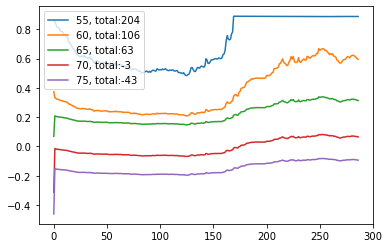

In [361]:
%matplotlib inline
stpts = [55., 60., 65., 70., 75.]
for stpt in stpts:
    env2 = get_env(model2, scaler2, ticker2, 0)
    scaled_stpt = env2.scale_setpoint([stpt])
    rewards = helpers.rewards(env2, lambda x: scaled_stpt)[0]
    plt.plot(rewards, label='{:.0f}, total:{:.0f}'.format(stpt, sum(rewards)))
plt.legend()

### Benchmark Controllers

In [459]:
from controllers.baseline_control import SimpleFeedbackController

class UpDownController(SimpleFeedbackController):
    
    def __init__(self, model_fn, scaler_fn, seed=None):
        super().__init__(bounds=((-1, 1.),), stepsize=0.05, window=1, seed=seed)
        self.model_fn = model_fn
        self.scaler_fn = scaler_fn
    
    def feedback(self, newstate):
        if len(self._actions) == 0:
            return 0.
        state = self._states[-1]
        x = np.concatenate((state, self._actions[-1]))
        x = self.scaler_fn(x.reshape(1, -1))
        x[-1] = self._actions[-1][0] # action is in [-1,1] range already
        temp_cond_in, temp_cond_out, pow_fan = self.model_fn(x)[0]
        reward = ((state[2] - temp_cond_in) / \
                  (state[2] - state[0] + 1e-2)) - \
                 (max(pow_fan, 0) / 10)
        return np.clip(reward, -1, 1)

    def starting_action(self, x):
        return self.random.uniform(*self.bounds[0])

class FixedApproachController:
    
    def __init__(self, approach: float):
        self.approach = approach
    
    def predict(self, state):
        wetbulb = state[0]
        setpoint = np.array((self.approach + wetbulb,))
        return (setpoint - 65) / 10., 1.

class ModelPredictiveController:
    
    def __init__(self, model_fn, scaler_fn, resolution=21):
        self.model_fn = model_fn
        self.scaler_fn = scaler_fn
        self.resolution = resolution
        self.bounds = np.asarray([[-1, 1]])
        self.actions = np.linspace(self.bounds[0][0], self.bounds[0][1], num=resolution, endpoint=True).reshape(-1, 1)

    def predict(self, state):
        x = np.tile(state, (self.resolution, 1))
        x = np.hstack((x, self.actions))
        x = self.scaler_fn(x)
        x[:, -1] = self.actions[:, 0]
        y = self.model_fn(x)
        temp_cond_in, temp_cond_out, pow_fan = y[:,0], y[:,1], y[:,2]
        reward = ((state[2] - temp_cond_in) / \
                  (state[2] - state[0] + 1e-2)) - \
                 (np.fmax(pow_fan, 0) / 10)
        best = np.argmax(reward)
        return self.actions[best], 1.
        

## Transfer

In [224]:
# RL hyperparameter search
def objective(trial: optuna.Trial):
    params = dict(
        policy = rl.ActorCriticBox,
        activation = nn.Tanh,
        state_dim = len(state_vars),
        action_dim = 1,
        n_latent_var = trial.suggest_int('n_latent_var', 16, 128),
        lr = trial.suggest_loguniform('lr', 1e-4, 1e-1),
        gamma = 0.,
        epochs = trial.suggest_int('epochs', 1, 10),
        update_interval = trial.suggest_int('update_interval', 16, 288, log=True)
    )
    
    env = get_env(model2, scaler2, ticker2, 0)
    agent = rl.PPO(env = env, seed=0, **params)
    rewards = agent.learn(timesteps=trial.suggest_int('timesteps', 288*10, 288*30),
                          reward_aggregation='episodic.normalized')
    feedback = np.mean(rewards[-5:])
    return feedback

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2021-07-23 00:24:18,768] A new study created in memory with name: no-name-8ea774f1-fa59-4828-bbe5-d4e421fe0188


  0%|          | 0/7749 [00:00<?, ?it/s]

[I 2021-07-23 00:25:04,280] Trial 0 finished with value: 0.5901124749891432 and parameters: {'n_latent_var': 85, 'lr': 0.002225349293209078, 'epochs': 4, 'update_interval': 71, 'timesteps': 7749}. Best is trial 0 with value: 0.5901124749891432.


  0%|          | 0/7557 [00:00<?, ?it/s]

[I 2021-07-23 00:26:16,416] Trial 1 finished with value: 0.6076150091644463 and parameters: {'n_latent_var': 25, 'lr': 0.0007133896655054223, 'epochs': 10, 'update_interval': 96, 'timesteps': 7557}. Best is trial 1 with value: 0.6076150091644463.


  0%|          | 0/4526 [00:00<?, ?it/s]

[I 2021-07-23 00:26:57,215] Trial 2 finished with value: 0.4877830077965729 and parameters: {'n_latent_var': 31, 'lr': 0.029924061647570523, 'epochs': 9, 'update_interval': 86, 'timesteps': 4526}. Best is trial 1 with value: 0.6076150091644463.


  0%|          | 0/4808 [00:00<?, ?it/s]

[I 2021-07-23 00:27:30,617] Trial 3 finished with value: 0.504334295573074 and parameters: {'n_latent_var': 92, 'lr': 0.00015505513228330657, 'epochs': 6, 'update_interval': 185, 'timesteps': 4808}. Best is trial 1 with value: 0.6076150091644463.


  0%|          | 0/3260 [00:00<?, ?it/s]

[I 2021-07-23 00:27:59,044] Trial 4 finished with value: 0.5179510795177067 and parameters: {'n_latent_var': 81, 'lr': 0.00036388603500629973, 'epochs': 9, 'update_interval': 41, 'timesteps': 3260}. Best is trial 1 with value: 0.6076150091644463.


  0%|          | 0/8037 [00:00<?, ?it/s]

[I 2021-07-23 00:28:46,793] Trial 5 finished with value: 0.546631900444402 and parameters: {'n_latent_var': 88, 'lr': 0.012987790150028274, 'epochs': 4, 'update_interval': 61, 'timesteps': 8037}. Best is trial 1 with value: 0.6076150091644463.


  0%|          | 0/5020 [00:00<?, ?it/s]

[I 2021-07-23 00:29:06,850] Trial 6 finished with value: 0.6417714802150394 and parameters: {'n_latent_var': 56, 'lr': 0.0038029800201064283, 'epochs': 1, 'update_interval': 121, 'timesteps': 5020}. Best is trial 6 with value: 0.6417714802150394.


  0%|          | 0/6688 [00:00<?, ?it/s]

[I 2021-07-23 00:29:33,868] Trial 7 finished with value: 0.5759293438423089 and parameters: {'n_latent_var': 112, 'lr': 0.027978919419120275, 'epochs': 1, 'update_interval': 77, 'timesteps': 6688}. Best is trial 6 with value: 0.6417714802150394.


  0%|          | 0/6692 [00:00<?, ?it/s]

[I 2021-07-23 00:30:14,046] Trial 8 finished with value: 0.31670334471687916 and parameters: {'n_latent_var': 24, 'lr': 0.00013976282980239694, 'epochs': 4, 'update_interval': 222, 'timesteps': 6692}. Best is trial 6 with value: 0.6417714802150394.


  0%|          | 0/5304 [00:00<?, ?it/s]

[I 2021-07-23 00:31:00,174] Trial 9 finished with value: 0.6852850526002816 and parameters: {'n_latent_var': 83, 'lr': 0.00020506894218892135, 'epochs': 8, 'update_interval': 251, 'timesteps': 5304}. Best is trial 9 with value: 0.6852850526002816.


  0%|          | 0/3200 [00:00<?, ?it/s]

[I 2021-07-23 00:31:25,176] Trial 10 finished with value: 0.5036342626826773 and parameters: {'n_latent_var': 127, 'lr': 0.0008690600006155378, 'epochs': 7, 'update_interval': 18, 'timesteps': 3200}. Best is trial 9 with value: 0.6852850526002816.


  0%|          | 0/5136 [00:00<?, ?it/s]

[I 2021-07-23 00:31:46,260] Trial 11 finished with value: 0.6463629213484093 and parameters: {'n_latent_var': 57, 'lr': 0.005405720037228628, 'epochs': 1, 'update_interval': 156, 'timesteps': 5136}. Best is trial 9 with value: 0.6852850526002816.


  0%|          | 0/5754 [00:00<?, ?it/s]

[I 2021-07-23 00:32:31,896] Trial 12 finished with value: 0.681630898459054 and parameters: {'n_latent_var': 51, 'lr': 0.005556821538947227, 'epochs': 7, 'update_interval': 236, 'timesteps': 5754}. Best is trial 9 with value: 0.6852850526002816.


  0%|          | 0/6535 [00:00<?, ?it/s]

[I 2021-07-23 00:33:23,169] Trial 13 finished with value: 0.5759320699841944 and parameters: {'n_latent_var': 59, 'lr': 0.09948042837145252, 'epochs': 7, 'update_interval': 264, 'timesteps': 6535}. Best is trial 9 with value: 0.6852850526002816.


  0%|          | 0/5871 [00:00<?, ?it/s]

[I 2021-07-23 00:34:13,310] Trial 14 finished with value: 0.6360642106967641 and parameters: {'n_latent_var': 42, 'lr': 0.0014958182471354604, 'epochs': 8, 'update_interval': 287, 'timesteps': 5871}. Best is trial 9 with value: 0.6852850526002816.


  0%|          | 0/4135 [00:00<?, ?it/s]

[I 2021-07-23 00:34:44,092] Trial 15 finished with value: 0.44945506706699445 and parameters: {'n_latent_var': 105, 'lr': 0.00785327415662403, 'epochs': 6, 'update_interval': 33, 'timesteps': 4135}. Best is trial 9 with value: 0.6852850526002816.


  0%|          | 0/5693 [00:00<?, ?it/s]

[I 2021-07-23 00:35:41,126] Trial 16 finished with value: 0.6820658095248688 and parameters: {'n_latent_var': 71, 'lr': 0.00028103409454350713, 'epochs': 10, 'update_interval': 152, 'timesteps': 5693}. Best is trial 9 with value: 0.6852850526002816.


  0%|          | 0/5801 [00:00<?, ?it/s]

[I 2021-07-23 00:36:38,097] Trial 17 finished with value: 0.6866045577942229 and parameters: {'n_latent_var': 70, 'lr': 0.00028199402187643625, 'epochs': 10, 'update_interval': 149, 'timesteps': 5801}. Best is trial 17 with value: 0.6866045577942229.


  0%|          | 0/4163 [00:00<?, ?it/s]

[I 2021-07-23 00:37:17,199] Trial 18 finished with value: 0.2435504689160526 and parameters: {'n_latent_var': 69, 'lr': 0.00010550675357686198, 'epochs': 9, 'update_interval': 129, 'timesteps': 4163}. Best is trial 17 with value: 0.6866045577942229.


  0%|          | 0/7082 [00:00<?, ?it/s]

[I 2021-07-23 00:38:26,285] Trial 19 finished with value: 0.15109623106669418 and parameters: {'n_latent_var': 101, 'lr': 0.0004714579160950321, 'epochs': 10, 'update_interval': 187, 'timesteps': 7082}. Best is trial 17 with value: 0.6866045577942229.


  0%|          | 0/6036 [00:00<?, ?it/s]

[I 2021-07-23 00:39:18,375] Trial 20 finished with value: 0.6358636992126094 and parameters: {'n_latent_var': 123, 'lr': 0.00020171563994963166, 'epochs': 8, 'update_interval': 50, 'timesteps': 6036}. Best is trial 17 with value: 0.6866045577942229.


  0%|          | 0/5417 [00:00<?, ?it/s]

[I 2021-07-23 00:40:12,224] Trial 21 finished with value: 0.6827236546179277 and parameters: {'n_latent_var': 72, 'lr': 0.00022640322575283078, 'epochs': 10, 'update_interval': 132, 'timesteps': 5417}. Best is trial 17 with value: 0.6866045577942229.


  0%|          | 0/5294 [00:00<?, ?it/s]

[I 2021-07-23 00:41:05,816] Trial 22 finished with value: 0.679346229732648 and parameters: {'n_latent_var': 77, 'lr': 0.00010381057507540042, 'epochs': 10, 'update_interval': 108, 'timesteps': 5294}. Best is trial 17 with value: 0.6866045577942229.


  0%|          | 0/3800 [00:00<?, ?it/s]

[I 2021-07-23 00:41:38,096] Trial 23 finished with value: 0.3997128068815444 and parameters: {'n_latent_var': 73, 'lr': 0.0006569217147514847, 'epochs': 8, 'update_interval': 189, 'timesteps': 3800}. Best is trial 17 with value: 0.6866045577942229.


  0%|          | 0/8620 [00:00<?, ?it/s]

[I 2021-07-23 00:42:57,757] Trial 24 finished with value: 0.45544237402520327 and parameters: {'n_latent_var': 66, 'lr': 0.00024025675598915918, 'epochs': 9, 'update_interval': 140, 'timesteps': 8620}. Best is trial 17 with value: 0.6866045577942229.


  0%|          | 0/6287 [00:00<?, ?it/s]

[I 2021-07-23 00:44:00,372] Trial 25 finished with value: 0.5944138888113584 and parameters: {'n_latent_var': 98, 'lr': 0.0016277255485946448, 'epochs': 10, 'update_interval': 271, 'timesteps': 6287}. Best is trial 17 with value: 0.6866045577942229.


  0%|          | 0/5562 [00:00<?, ?it/s]

[I 2021-07-23 00:44:48,014] Trial 26 finished with value: 0.680826976565343 and parameters: {'n_latent_var': 48, 'lr': 0.0004246601146654951, 'epochs': 8, 'update_interval': 105, 'timesteps': 5562}. Best is trial 17 with value: 0.6866045577942229.


  0%|          | 0/4769 [00:00<?, ?it/s]

[I 2021-07-23 00:45:31,013] Trial 27 finished with value: 0.5370217638165883 and parameters: {'n_latent_var': 81, 'lr': 0.0010555379523788718, 'epochs': 9, 'update_interval': 204, 'timesteps': 4769}. Best is trial 17 with value: 0.6866045577942229.


  0%|          | 0/6153 [00:00<?, ?it/s]

[I 2021-07-23 00:46:11,916] Trial 28 finished with value: 0.5569899054535826 and parameters: {'n_latent_var': 64, 'lr': 0.00011006655250921572, 'epochs': 5, 'update_interval': 152, 'timesteps': 6153}. Best is trial 17 with value: 0.6866045577942229.


  0%|          | 0/5358 [00:00<?, ?it/s]

[I 2021-07-23 00:46:37,804] Trial 29 finished with value: 0.6730438069904319 and parameters: {'n_latent_var': 89, 'lr': 0.00021283499203978264, 'epochs': 2, 'update_interval': 63, 'timesteps': 5358}. Best is trial 17 with value: 0.6866045577942229.


In [531]:
agent_params = dict(
    policy = rl.ActorCriticBox,
    activation = nn.Tanh,
    state_dim = len(state_vars),
    action_dim = 1,
    n_latent_var = 64,
    lr = 3e-4,
    gamma = 0.,
    epochs = 10,
    update_interval = 150,
    truncate=False,
    seed=0
)
timesteps = 288 * 30

In [400]:
def transfer_experiment(agent_from, agent_to, transfer_model=None, timesteps=288*30, **agent_params):
    env_from, env_to = agent_from.env, agent_to.env
    if transfer_model is not None:
        env_model = get_env(transfer_model, env_to.scaler_fn, env_to.ticker_vars, 0)
        agentx = rl.PPO(env=env_model, **agent_params)
        agentx.policy.load_state_dict(agent_from.policy.state_dict())
        agentx.learn(timesteps // 10)
        agentx.env = get_env(transfer_model, env_to.scaler_fn, env_to.ticker_vars, 0)
        rewardsx = agentx.learn(timesteps=timesteps)
    else:
        agentx, rewardsx = None, None
    
    agentx_ = rl.PPO(env=None, **agent_params)
    agentx_.env = get_env(env_to.model_fn, env_to.scaler_fn, env_to.ticker_vars, 0)
    agentx_.policy.load_state_dict(agent_from.policy.state_dict())
    rewardsx_ = agentx_.learn(timesteps=timesteps)
    
    return (agentx, rewardsx), (agentx_, rewardsx_)

In [ ]:
import warnings
warnings.simplefilter("error")

### Transfer Across Towers

#### Env 1 Policy

  0%|          | 0/8640 [00:00<?, ?it/s]

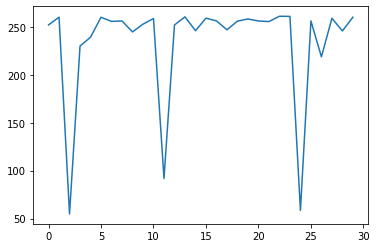

In [532]:
%matplotlib inline
# Training on environment 1
env1 = get_env(model1, scaler1, ticker1, 0)
agent1 = rl.PPO(env = env1, **agent_params)
rewards1 = agent1.learn(timesteps=timesteps)
plt.plot(stats.rolling_mean(rewards1, 1))

Text(0.5, 1.0, 'Tower 1 control')

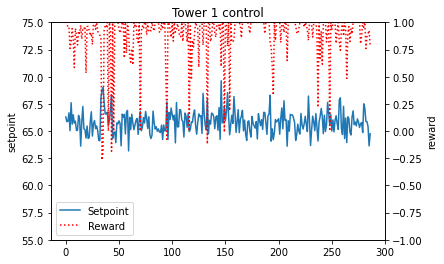

In [584]:
%matplotlib inline
env1_ = get_env(model1, scaler1, ticker2[:1], seed=0)
res = helpers.get_from_env(('reward', 'action'), env1_, lambda s: agent1.policy.predict(s)[0])
actions = np.asarray(res['action']).squeeze()
rewards = np.asarray(res['reward']).squeeze()
actions = np.asarray(actions) * 10 + 65
# plt.figure(figsize=(10,5))
s, = plt.plot(actions)
plt.ylabel('setpoint')
plt.ylim(55, 75)
plt.twinx()
r, = plt.plot(rewards, c='r', ls=':')
plt.ylabel('reward')
plt.ylim(-1, 1)
plt.legend((s, r), ('Setpoint', 'Reward'))
plt.title('Tower 1 control')

#### Env 2 Policy

  0%|          | 0/8640 [00:00<?, ?it/s]

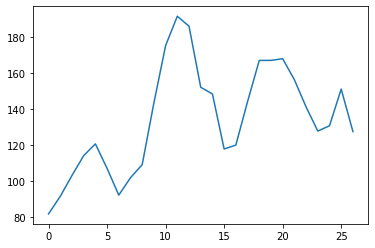

In [533]:
%matplotlib inline
# Training environment 2
env2 = get_env(model2, scaler2, ticker2, 0)
agent2 = rl.PPO(env = env2, **agent_params)
rewards2 = agent2.learn(timesteps=timesteps)
plt.plot(stats.rolling_mean(rewards2, 4))

Text(0.5, 1.0, 'Tower 2 control')

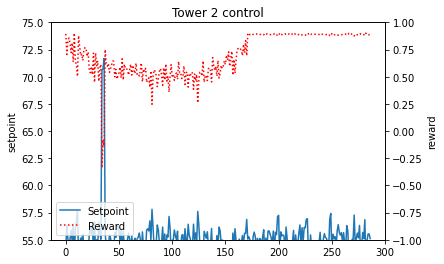

In [585]:
%matplotlib inline
env2_ = get_env(model2, scaler2, ticker2[:1], seed=0)
res = helpers.get_from_env(('reward', 'action'), env2_, lambda s: agent2.policy.predict(s)[0])
actions = np.asarray(res['action']).squeeze()
rewards = np.asarray(res['reward']).squeeze()
actions = np.asarray(actions) * 10 + 65
# plt.figure(figsize=(10,5))
s, = plt.plot(actions)
plt.ylabel('setpoint')
plt.ylim(55, 75)
plt.twinx()
r, = plt.plot(rewards, c='r', ls=':')
plt.ylabel('reward')
plt.ylim(-1, 1)
plt.legend((s, r), ('Setpoint', 'Reward'))
plt.title('Tower 2 control')

#### Model Transfer

In [522]:
test_point = x_val2[:1]

In [ ]:
# Model 1 prediction with model 2 data
vary = (0, 5)
s1 = model_surface(lambda x: model1.predict(x)[:,0], test_point, vary, ((-1,1),(-1,1)), (10,10))
s2 = model_surface(lambda x: model2.predict(x)[:,0], test_point, vary, ((-1,1),(-1,1)), (10,10))

# fitting model1 on model2 data
model12 = helpers.clone(model1, dict(n_iter_=0, t_=0, loss_curve_=[], best_loss_=np.inf))
model12.set_params(warm_start=True, verbose=True)
model12.fit(x_val2, y_val2)
# model12.fit(x_train2, y_train2)

<IPython.core.display.Javascript object>


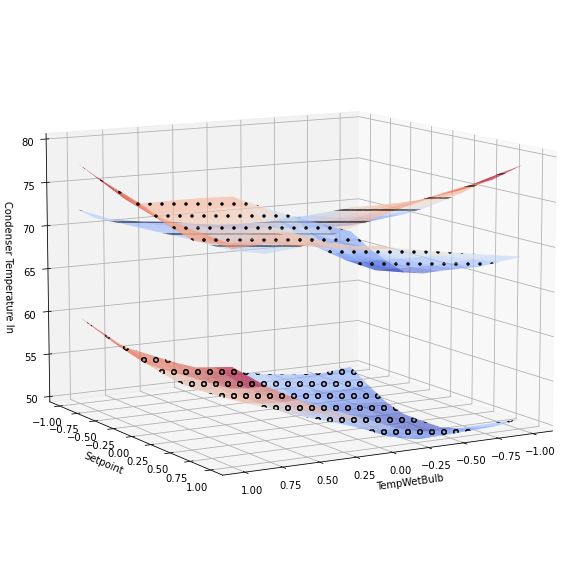

In [626]:
%matplotlib notebook
s12 = model_surface(lambda x: model12.predict(x)[:,0], test_point, vary, ((-1,1),(-1,1)), (10,10))

plot_surface(*s1, fig_kwargs={'figsize':(8,8)}, cmap=plt.cm.coolwarm, hatch='o', alpha=0.6)
ax = plt.gca()
plot_surface(*s2, cmap=plt.cm.coolwarm, ax=ax, hatch='-', alpha=0.6)
plot_surface(*s12, cmap=plt.cm.coolwarm, ax=ax, hatch='.', alpha=0.6)
ax.set_zlim(50, 80)
plt.xlabel(colsx[vary[0]])
plt.ylabel(colsx[vary[1]] if vary[1]<len(colsx) else 'Setpoint')
ax.set_zlabel('Condenser Temperature In')
ax.view_init(10, 60)
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

#### Policy transfer

In [249]:
# Transfer from env 1 to 2, using model12 as intermediate
env12 = get_env(model12, scaler2, ticker2, 0)
agent12 = rl.PPO(env = env12, **agent_params)
agent12.policy.load_state_dict(agent1.policy.state_dict())
agent12.learn(288 * 3)
agent12.env = get_env(model12, scaler2, ticker2, 0)
rewards12 = agent12.learn(timesteps=288*30)

  0%|          | 0/864 [00:00<?, ?it/s]

  0%|          | 0/8640 [00:00<?, ?it/s]

In [250]:
# Transfer w/o model as intermediate
agent12_ = rl.PPO(env = env2, **agent_params)
agent12_.policy.load_state_dict(agent1.policy.state_dict())
rewards12_ = agent12_.learn(timesteps=288*30)

  0%|          | 0/8640 [00:00<?, ?it/s]

In [534]:
# transferring across
(agent12, rewards12), (agent12_, rewards12_) = \
    transfer_experiment(agent1, agent2, transfer_model=model12, timesteps=timesteps, **agent_params)

  0%|          | 0/864 [00:00<?, ?it/s]

  0%|          | 0/8640 [00:00<?, ?it/s]

  0%|          | 0/8640 [00:00<?, ?it/s]

Text(0.5, 1.0, 'RL Performance')

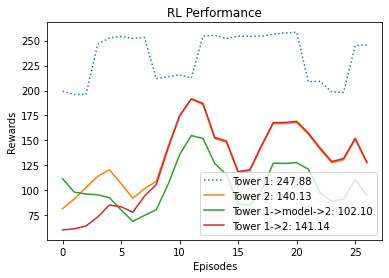

In [535]:
# Learning performance
plt.plot(stats.rolling_mean(rewards1, 4), label='Tower 1: %.2f' % np.mean(rewards1[-5:]), ls=':')
plt.plot(stats.rolling_mean(rewards2, 4), label='Tower 2: %.2f' % np.mean(rewards2[-5:]))
plt.plot(stats.rolling_mean(rewards12, 4), label='Tower 1->model->2: %.2f' % np.mean(rewards12[-5:]))
plt.plot(stats.rolling_mean(rewards12_, 4), label='Tower 1->2: %.2f' % np.mean(rewards12_[-5:]))
plt.ylabel('Rewards')
plt.xlabel('Episodes')
plt.legend()
plt.title('RL Performance')

In [587]:
# Operational performance
results = dict(r2=[], r12=[], r12_=[], rud=[], rfa=[], rmpc=[])
for i in trange(10, leave=False):
    _seed = i
    # rprod1 = helpers.get_from_env(('reward',), get_env(model2, scaler2, ticker2, _seed), lambda x: agent1.predict(x)[0])['reward'][0]
    results['r2'].append(helpers.get_from_env(('reward',), get_env(model2, scaler2, ticker2, _seed), lambda x: agent2.predict(x)[0])['reward'][0])
    results['r12'].append(helpers.get_from_env(('reward',), get_env(model2, scaler2, ticker2, _seed), lambda x: agent12.predict(x)[0])['reward'][0])
    results['r12_'].append(helpers.get_from_env(('reward',), get_env(model2, scaler2, ticker2, _seed), lambda x: agent12_.predict(x)[0])['reward'][0])

    updown = UpDownController(model2.predict, scaler2.transform, 0)
    results['rud'].append(helpers.get_from_env(('reward',), get_env(model2, scaler2, ticker2, _seed), lambda x: updown.predict(x)[0])['reward'][0])
    fixed = FixedApproachController(approach=5)
    results['rfa'].append(helpers.get_from_env(('reward',), get_env(model2, scaler2, ticker2, _seed), lambda x: fixed.predict(x)[0])['reward'][0])
    mpc = ModelPredictiveController(modelb.predict, scalerb.transform, resolution=21)
    results['rmpc'].append(helpers.get_from_env(('reward',), get_env(modeln, scalern, tickern, _seed), lambda x: mpc.predict(x)[0])['reward'][0])

keys = list(results.keys())
resagg12 = {}
for key in keys:
    results[key] = helpers.homogenous_array(results[key])
    resagg12[key+'_mean'] = np.nanmean(results[key], axis=0)
    resagg12[key+'_std'] = np.nanstd(results[key], axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Transfer: tower 1 to 2')

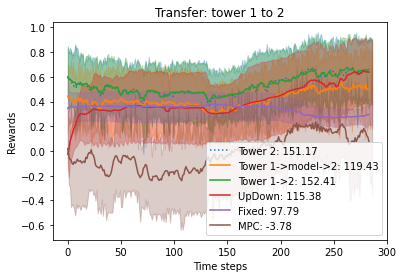

In [588]:
# plt.plot(stats.rolling_mean(rprod1, 4), label='Tower 1 {:.2f}'.format(sum(rprod1)), ls=':')
r = resagg12
p = plt.plot(stats.rolling_mean(r['r2_mean'], 4), label='Tower 2: {:.2f}'.format(sum(r['r2_mean'])), ls=':')
plt.fill_between(np.arange(len(r['r2_mean'])), r['r2_mean']+r['r2_std'], r['r2_mean']-r['r2_std'], color=p[0].get_color(), alpha=0.3)
p = plt.plot(stats.rolling_mean(r['r12_mean'], 4), label='Tower 1->model->2: {:.2f}'.format(sum(r['r12_mean'])))
plt.fill_between(np.arange(len(r['r12_mean'])), r['r12_mean']+r['r12_std'], r['r12_mean']-r['r12_std'], color=p[0].get_color(), alpha=0.3)
p = plt.plot(stats.rolling_mean(r['r12__mean'], 4), label='Tower 1->2: {:.2f}'.format(sum(r['r12__mean'])))
plt.fill_between(np.arange(len(r['r12__mean'])), r['r12__mean']+r['r12__std'], r['r12__mean']-r['r12__std'], color=p[0].get_color(), alpha=0.3)
p = plt.plot(stats.rolling_mean(r['rud_mean'], 4), label='UpDown: {:.2f}'.format(sum(r['rud_mean'])))
plt.fill_between(np.arange(len(r['rud_mean'])), r['rud_mean']+r['rud_std'], r['rud_mean']-r['rud_std'], color=p[0].get_color(), alpha=0.3)
p = plt.plot(stats.rolling_mean(r['rfa_mean'], 4), label='Fixed: {:.2f}'.format(sum(r['rfa_mean'])))
plt.fill_between(np.arange(len(r['rfa_mean'])), r['rfa_mean']+r['rfa_std'], r['rfa_mean']-r['rfa_std'], color=p[0].get_color(), alpha=0.3)
p = plt.plot(stats.rolling_mean(r['rmpc_mean'], 4), label='MPC: {:.2f}'.format(sum(r['rmpc_mean'])))
plt.fill_between(np.arange(len(r['rmpc_mean'])), r['rmpc_mean']+r['rmpc_std'], r['rmpc_mean']-r['rmpc_std'], color=p[0].get_color(), alpha=0.3)
plt.ylabel('Rewards')
plt.xlabel('Time steps')
plt.legend()
plt.title('Transfer: tower 1 to 2')

### Transfer Inside Tower

In [538]:
# Chiller/tower data to use
ch = ch2
ticker = ticker2

In [470]:
similarity_idx = ['TempWetBulb', 'TempAmbient', 'Tonnage'] # variables for judging env similarity in ticker
similarity_matrix = stats.timeseries.similarity_matrix(ticker, similarity_idx)

In [471]:
clusterer = cluster.SpectralClustering(n_clusters=2, affinity='precomputed')
cluster_labels = clusterer.fit_predict(similarity_matrix)
projecter = manifold.SpectralEmbedding(affinity='precomputed')
coords = projecter.fit_transform(similarity_matrix)

Text(0.5, 1.0, 'Episodes clustered by\n independent state variables')

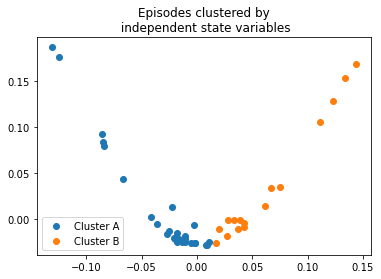

In [568]:
%matplotlib inline
coords0 = coords[cluster_labels==0]
coords1 = coords[cluster_labels==1]
plt.scatter(coords0[:,0], coords0[:,1], label='Cluster A')
plt.scatter(coords1[:,0], coords1[:,1], label='Cluster B')
plt.legend()
plt.title('Episodes clustered by\n independent state variables')

#### Env A Policy

In [539]:
tickera = [t for label, t in zip(cluster_labels, ticker) if label==0]
cha = ch.loc[pd.concat(tickera).index]
x_traina, x_vala, y_traina, y_vala, _, scalera = get_env_data(cha, colsx, colsy, ticker_vars)
modela = train_model(x_traina, y_traina)
enva = get_env(modela, scalera, tickera, 0)

Iteration 1, loss = 1307.60855698
Iteration 2, loss = 1113.52361339
Iteration 3, loss = 449.57305302
Iteration 4, loss = 91.50368840
Iteration 5, loss = 43.75202981
Iteration 6, loss = 20.39955704
Iteration 7, loss = 13.93541449
Iteration 8, loss = 12.05738828
Iteration 9, loss = 10.69169286
Iteration 10, loss = 9.47040774
Iteration 11, loss = 8.45343818
Iteration 12, loss = 7.58274708
Iteration 13, loss = 6.78127849
Iteration 14, loss = 6.03869400
Iteration 15, loss = 5.32524827
Iteration 16, loss = 4.66653080
Iteration 17, loss = 4.11049591
Iteration 18, loss = 3.65140868
Iteration 19, loss = 3.24768630
Iteration 20, loss = 2.92253105
Iteration 21, loss = 2.64120334
Iteration 22, loss = 2.39054846
Iteration 23, loss = 2.17387495
Iteration 24, loss = 1.97810537
Iteration 25, loss = 1.78743047
Iteration 26, loss = 1.62515807
Iteration 27, loss = 1.48870800
Iteration 28, loss = 1.37141695
Iteration 29, loss = 1.27356042
Iteration 30, loss = 1.18591499
Iteration 31, loss = 1.10306569
Ite

Iteration 254, loss = 0.39380988
Iteration 255, loss = 0.38943840
Iteration 256, loss = 0.39441857
Iteration 257, loss = 0.39016955
Iteration 258, loss = 0.38920361
Iteration 259, loss = 0.38810720
Iteration 260, loss = 0.38749262
Iteration 261, loss = 0.38782138
Iteration 262, loss = 0.38655715
Iteration 263, loss = 0.39593365
Iteration 264, loss = 0.39283429
Iteration 265, loss = 0.39075120
Iteration 266, loss = 0.38623232
Iteration 267, loss = 0.38898372
Iteration 268, loss = 0.38446333
Iteration 269, loss = 0.38378649
Iteration 270, loss = 0.38472539
Iteration 271, loss = 0.39491302
Iteration 272, loss = 0.40446632
Iteration 273, loss = 0.38319734
Iteration 274, loss = 0.38227553
Iteration 275, loss = 0.39367641
Iteration 276, loss = 0.40589769
Iteration 277, loss = 0.38556262
Iteration 278, loss = 0.38417469
Iteration 279, loss = 0.38855560
Iteration 280, loss = 0.39032361
Iteration 281, loss = 0.38599416
Iteration 282, loss = 0.38183525
Iteration 283, loss = 0.38158302
Iteration 

  0%|          | 0/8640 [00:00<?, ?it/s]

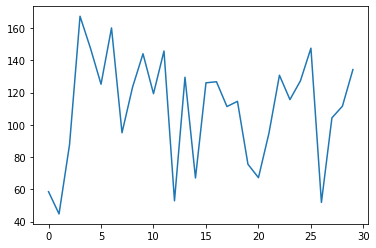

In [540]:
# Training on environment a
agenta = rl.PPO(env=enva, **agent_params)
rewardsa = agenta.learn(timesteps=timesteps)
plt.plot(rewardsa)

#### Env B Policy

In [541]:
tickerb = [t for label, t in zip(cluster_labels, ticker) if label==1]
chb = ch.loc[pd.concat(tickerb).index]
x_trainb, x_valb, y_trainb, y_valb, _, scalerb = get_env_data(chb, colsx, colsy, ticker_vars)
modelb = train_model(x_trainb, y_trainb)
envb = get_env(modelb, scalerb, tickerb, 0)

Iteration 1, loss = 1496.59567001
Iteration 2, loss = 1449.86131817
Iteration 3, loss = 1363.63686907
Iteration 4, loss = 1169.46776584
Iteration 5, loss = 792.13311092
Iteration 6, loss = 335.39898595
Iteration 7, loss = 107.05508369
Iteration 8, loss = 38.68028548
Iteration 9, loss = 22.36417815
Iteration 10, loss = 19.73931084
Iteration 11, loss = 18.23328467
Iteration 12, loss = 17.12453437
Iteration 13, loss = 16.18645402
Iteration 14, loss = 15.27297251
Iteration 15, loss = 14.41694570
Iteration 16, loss = 13.53348870
Iteration 17, loss = 12.68686466
Iteration 18, loss = 11.86233939
Iteration 19, loss = 11.05100557
Iteration 20, loss = 10.28363946
Iteration 21, loss = 9.55611424
Iteration 22, loss = 8.86970333
Iteration 23, loss = 8.22181982
Iteration 24, loss = 7.60753933
Iteration 25, loss = 7.05921522
Iteration 26, loss = 6.53572253
Iteration 27, loss = 6.04727397
Iteration 28, loss = 5.60674980
Iteration 29, loss = 5.19615624
Iteration 30, loss = 4.82557919
Iteration 31, loss

Iteration 266, loss = 0.30515129
Iteration 267, loss = 0.30834000
Iteration 268, loss = 0.30747710
Iteration 269, loss = 0.30394245
Iteration 270, loss = 0.30358304
Iteration 271, loss = 0.30333902
Iteration 272, loss = 0.30069171
Iteration 273, loss = 0.30018034
Iteration 274, loss = 0.30090896
Iteration 275, loss = 0.29983069
Iteration 276, loss = 0.29818515
Iteration 277, loss = 0.30108846
Iteration 278, loss = 0.29543066
Iteration 279, loss = 0.29704836
Iteration 280, loss = 0.29809170
Iteration 281, loss = 0.29468702
Iteration 282, loss = 0.29564491
Iteration 283, loss = 0.29454319
Iteration 284, loss = 0.29239006
Iteration 285, loss = 0.29216719
Iteration 286, loss = 0.29268547
Iteration 287, loss = 0.29090879
Iteration 288, loss = 0.29047407
Iteration 289, loss = 0.28970356
Iteration 290, loss = 0.28797223
Iteration 291, loss = 0.28911364
Iteration 292, loss = 0.28627168
Iteration 293, loss = 0.28594089
Iteration 294, loss = 0.28586850
Iteration 295, loss = 0.28569809
Iteration 

  0%|          | 0/8640 [00:00<?, ?it/s]

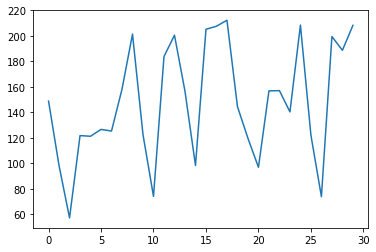

In [542]:
# Training on environment b
agentb = rl.PPO(env=envb, **agent_params)
rewardsb = agentb.learn(timesteps=timesteps)
plt.plot(rewardsb)

#### Model Transfer

In [ ]:
# Model 1 prediction with model 2 data
vary = (0, 5)
sa = model_surface(lambda x: modela.predict(x)[:,0], test_point, vary, ((-1,1),(-1,1)), (10,10))
sb = model_surface(lambda x: modelb.predict(x)[:,0], test_point, vary, ((-1,1),(-1,1)), (10,10))

# fitting model1 on model2 data
modelab = helpers.clone(modela, dict(n_iter_=0, t_=0, loss_curve_=[], best_loss_=np.inf))
modelab.set_params(warm_start=True, verbose=True)
modelab.fit(x_valb, y_valb)
# modelab.fit(x_trainb, y_trainb)

<IPython.core.display.Javascript object>


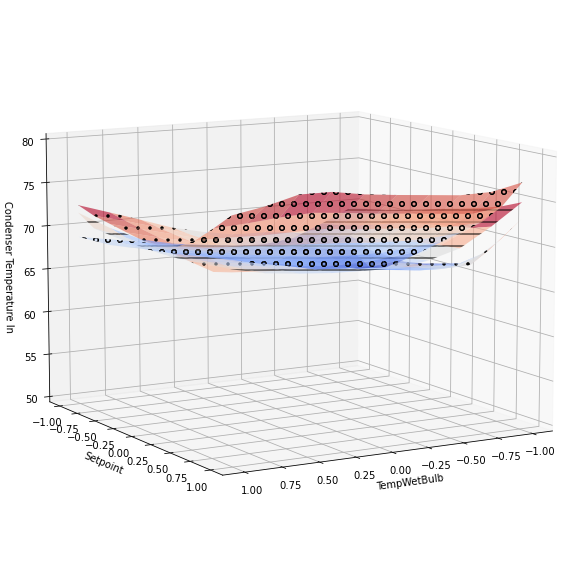

In [627]:
%matplotlib notebook
sab = model_surface(lambda x: modelab.predict(x)[:,0], test_point, vary, ((-1,1),(-1,1)), (10,10))

plot_surface(*sa, fig_kwargs={'figsize':(8,8)}, cmap=plt.cm.coolwarm, hatch='o', alpha=0.6)
ax = plt.gca()
plot_surface(*sb, cmap=plt.cm.coolwarm, ax=ax, hatch='-', alpha=0.6)
plot_surface(*sab, cmap=plt.cm.coolwarm, ax=ax, hatch='.', alpha=0.6)

ax.set_zlim(50, 80)
plt.xlabel(colsx[vary[0]])
plt.ylabel(colsx[vary[1]] if vary[1]<len(colsx) else 'Setpoint')
ax.set_zlabel('Condenser Temperature In')
ax.view_init(10, 60)
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

#### Policy transfer

In [543]:
# transferring across
(agentab, rewardsab), (agentab_, rewardsab_) = \
    transfer_experiment(agenta, agentb, transfer_model=modelab, timesteps=288*30, **agent_params)

  0%|          | 0/864 [00:00<?, ?it/s]

  0%|          | 0/8640 [00:00<?, ?it/s]

  0%|          | 0/8640 [00:00<?, ?it/s]

Text(0.5, 1.0, 'RL training performance')

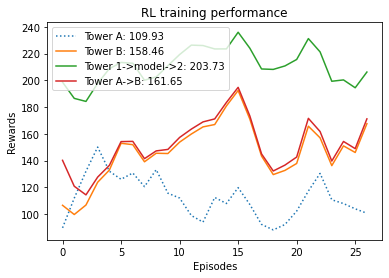

In [544]:
%matplotlib inline
# Learning performance
plt.plot(stats.rolling_mean(rewardsa, 4), label='Tower A: %.2f' % np.mean(rewardsa[-5:]), ls=':')
plt.plot(stats.rolling_mean(rewardsb, 4), label='Tower B: %.2f' % np.mean(rewardsb[-5:]))
plt.plot(stats.rolling_mean(rewardsab, 4), label='Tower 1->model->2: %.2f' % np.mean(rewardsab[-5:]))
plt.plot(stats.rolling_mean(rewardsab_, 4), label='Tower A->B: %.2f' % np.mean(rewardsab_[-5:]))
plt.ylabel('Rewards')
plt.xlabel('Episodes')
plt.legend()
plt.title('RL training performance')

In [560]:
# Operational performance
results = dict(ra=[], rb=[], rab=[], rab_=[], rud=[], rfa=[], rmpc=[])
for i in trange(10, leave=False):
    _seed = i
    results['ra'].append(helpers.get_from_env(('reward',), get_env(modelb, scalerb, tickerb, _seed), lambda x: agenta.predict(x)[0])['reward'][0])
    results['rb'].append(helpers.get_from_env(('reward',), get_env(modelb, scalerb, tickerb, _seed), lambda x: agentb.predict(x)[0])['reward'][0])
    results['rab'].append(helpers.get_from_env(('reward',), get_env(modelb, scalerb, tickerb, _seed), lambda x: agentab.predict(x)[0])['reward'][0])
    results['rab_'].append(helpers.get_from_env(('reward',), get_env(modelb, scalerb, tickerb, _seed), lambda x: agentab_.predict(x)[0])['reward'][0])

    updown = UpDownController(modelb.predict, scalerb.transform, 0)
    results['rud'].append(helpers.get_from_env(('reward',), get_env(modelb, scalerb, tickerb, _seed), lambda x: updown.predict(x)[0])['reward'][0])
    fixed = FixedApproachController(approach=5)
    results['rfa'].append(helpers.get_from_env(('reward',), get_env(modelb, scalerb, tickerb, _seed), lambda x: fixed.predict(x)[0])['reward'][0])
    mpc = ModelPredictiveController(modelb.predict, scalerb.transform, resolution=21)
    results['rmpc'].append(helpers.get_from_env(('reward',), get_env(modelb, scalerb, tickerb, _seed), lambda x: mpc.predict(x)[0])['reward'][0])

keys = list(results.keys())
resaggab = {}
for key in keys:
    results[key] = helpers.homogenous_array(results[key])
    resaggab[key+'_mean'] = np.nanmean(results[key], axis=0)
    resaggab[key+'_std'] = np.nanstd(results[key], axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Transfer: Cluster A to B')

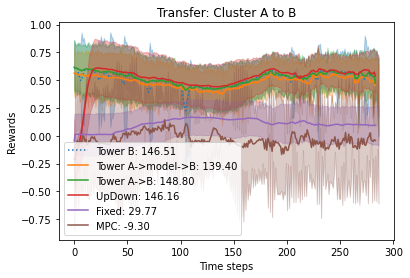

In [570]:
%matplotlib inline
r = resaggab
p = plt.plot(stats.rolling_mean(r['rb_mean'], 4), label='Tower B: {:.2f}'.format(sum(r['rb_mean'])), ls=':')
plt.fill_between(np.arange(len(r['rb_mean'])), r['rb_mean']+r['rb_std'], r['rb_mean']-r['rb_std'], color=p[0].get_color(), alpha=0.3)
p = plt.plot(stats.rolling_mean(r['rab_mean'], 4), label='Tower A->model->B: {:.2f}'.format(sum(r['rab_mean'])))
plt.fill_between(np.arange(len(r['rab_mean'])), r['rab_mean']+r['rab_std'], r['rab_mean']-r['rab_std'], color=p[0].get_color(), alpha=0.3)
p = plt.plot(stats.rolling_mean(r['rab__mean'], 4), label='Tower A->B: {:.2f}'.format(sum(r['rab__mean'])))
plt.fill_between(np.arange(len(r['rab__mean'])), r['rab__mean']+r['rab__std'], r['rab__mean']-r['rab__std'], color=p[0].get_color(), alpha=0.3)
p = plt.plot(stats.rolling_mean(r['rud_mean'], 4), label='UpDown: {:.2f}'.format(sum(r['rud_mean'])))
plt.fill_between(np.arange(len(r['rud_mean'])), r['rud_mean']+r['rud_std'], r['rud_mean']-r['rud_std'], color=p[0].get_color(), alpha=0.3)
p = plt.plot(stats.rolling_mean(r['rfa_mean'], 4), label='Fixed: {:.2f}'.format(sum(r['rfa_mean'])))
plt.fill_between(np.arange(len(r['rfa_mean'])), r['rfa_mean']+r['rfa_std'], r['rfa_mean']-r['rfa_std'], color=p[0].get_color(), alpha=0.3)
p = plt.plot(stats.rolling_mean(r['rmpc_mean'], 4), label='MPC: {:.2f}'.format(sum(r['rmpc_mean'])))
plt.fill_between(np.arange(len(r['rmpc_mean'])), r['rmpc_mean']+r['rmpc_std'], r['rmpc_mean']-r['rmpc_std'], color=p[0].get_color(), alpha=0.3)
plt.ylabel('Rewards')
plt.xlabel('Time steps')
plt.legend()
plt.title('Transfer: Cluster A to B')

### Transfer using stale data

In [547]:
# `old` or `o` suffix for old,
# `new` or `n` suffix for new
chold, chnew = ch1_ref, ch1

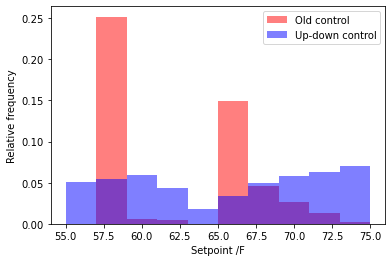

In [502]:
%matplotlib inline
bins = np.linspace(55, 75, num=11, endpoint=True)
plt.hist(chold['Setpoint'], label='Old control', density=True, bins=bins, color='r', alpha=0.5)
plt.hist(chnew['Setpoint'], label='Up-down control (new)', density=True, bins=bins, color='b', alpha=0.5)
plt.xlabel('Setpoint /F')
plt.ylabel('Relative frequency')
plt.legend()

#### Policy on old env

In [548]:
x_traino, x_valo, y_traino, y_valo, tickero, scalero = get_env_data(chold, colsx, colsy, ticker_vars)
modelo = train_model(x_traino, y_traino)
envo = get_env(modelo, scalero, tickero, 0)

Iteration 1, loss = 983.38780730
Iteration 2, loss = 8.87397894
Iteration 3, loss = 4.73282464
Iteration 4, loss = 3.29455616
Iteration 5, loss = 2.46915074
Iteration 6, loss = 1.78493998
Iteration 7, loss = 1.22601373
Iteration 8, loss = 1.08641391
Iteration 9, loss = 1.02661080
Iteration 10, loss = 0.97682366
Iteration 11, loss = 0.93242324
Iteration 12, loss = 0.89361797
Iteration 13, loss = 0.85663583
Iteration 14, loss = 0.82606136
Iteration 15, loss = 0.78825901
Iteration 16, loss = 0.75425102
Iteration 17, loss = 0.72491068
Iteration 18, loss = 0.69869988
Iteration 19, loss = 0.67630997
Iteration 20, loss = 0.65600641
Iteration 21, loss = 0.63963968
Iteration 22, loss = 0.62373561
Iteration 23, loss = 0.61048726
Iteration 24, loss = 0.59818376
Iteration 25, loss = 0.59124122
Iteration 26, loss = 0.57327160
Iteration 27, loss = 0.55448923
Iteration 28, loss = 0.54083379
Iteration 29, loss = 0.53311403
Iteration 30, loss = 0.52531693
Iteration 31, loss = 0.51949848
Iteration 32, l

  0%|          | 0/8640 [00:00<?, ?it/s]

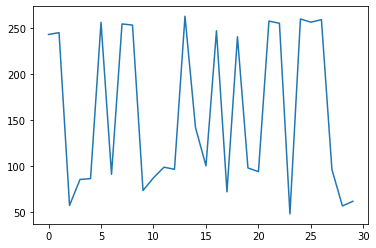

In [549]:
%matplotlib inline
# Training on environment old
agento = rl.PPO(env=envo, **agent_params)
rewardso = agento.learn(timesteps=timesteps)
plt.plot(rewardso)

#### Policy on new env

In [550]:
x_trainn, x_valn, y_trainn, y_valn, tickern, scalern = get_env_data(chnew, colsx, colsy, ticker_vars)
modeln = train_model(x_trainn, y_trainn)
envn = get_env(modeln, scalern, tickern, 0)

Iteration 1, loss = 1598.14362903
Iteration 2, loss = 1539.06836858
Iteration 3, loss = 1337.20589175
Iteration 4, loss = 796.05357920
Iteration 5, loss = 159.20277703
Iteration 6, loss = 23.19325489
Iteration 7, loss = 11.48340063
Iteration 8, loss = 10.08281981
Iteration 9, loss = 9.22053949
Iteration 10, loss = 8.52337081
Iteration 11, loss = 7.92338605
Iteration 12, loss = 7.40774151
Iteration 13, loss = 6.93545064
Iteration 14, loss = 6.49888624
Iteration 15, loss = 6.08692039
Iteration 16, loss = 5.71134957
Iteration 17, loss = 5.35175779
Iteration 18, loss = 5.01190148
Iteration 19, loss = 4.67885619
Iteration 20, loss = 4.30813909
Iteration 21, loss = 3.95301955
Iteration 22, loss = 3.63668346
Iteration 23, loss = 3.36086636
Iteration 24, loss = 3.12544321
Iteration 25, loss = 2.92456432
Iteration 26, loss = 2.75160901
Iteration 27, loss = 2.60117571
Iteration 28, loss = 2.46269092
Iteration 29, loss = 2.34507494
Iteration 30, loss = 2.23891890
Iteration 31, loss = 2.14431908
I

Iteration 265, loss = 0.63048442
Iteration 266, loss = 0.66196613
Iteration 267, loss = 0.63060483
Iteration 268, loss = 0.63923037
Iteration 269, loss = 0.63018559
Iteration 270, loss = 0.62442271
Iteration 271, loss = 0.63532961
Iteration 272, loss = 0.64671306
Iteration 273, loss = 0.62389959
Iteration 274, loss = 0.62569158
Iteration 275, loss = 0.62130152
Iteration 276, loss = 0.63464473
Iteration 277, loss = 0.62022513
Iteration 278, loss = 0.62562989
Iteration 279, loss = 0.61711657
Iteration 280, loss = 0.63792831
Iteration 281, loss = 0.62212882
Iteration 282, loss = 0.62208898
Iteration 283, loss = 0.63967849
Iteration 284, loss = 0.62090281
Iteration 285, loss = 0.62404230
Iteration 286, loss = 0.61877635
Iteration 287, loss = 0.61709834
Iteration 288, loss = 0.61697164
Iteration 289, loss = 0.62305768
Iteration 290, loss = 0.61419294
Iteration 291, loss = 0.61904223
Iteration 292, loss = 0.61533627
Iteration 293, loss = 0.61793723
Iteration 294, loss = 0.61637414
Iteration 

  0%|          | 0/8640 [00:00<?, ?it/s]

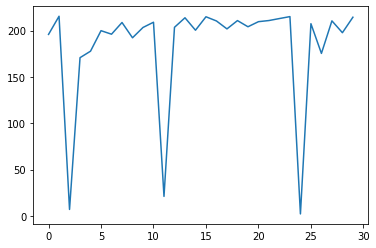

In [551]:
%matplotlib inline
# Training on environment new
agentn = rl.PPO(env=envn, **agent_params)
rewardsn = agentn.learn(timesteps=timesteps)
plt.plot(rewardsn)

#### Model Transfer

In [ ]:
# Model 1 prediction with model 2 data
vary = (0, 5)
so = model_surface(lambda x: modelo.predict(x)[:,0], test_point, vary, ((-1,1),(-1,1)), (10,10))
sn = model_surface(lambda x: modeln.predict(x)[:,0], test_point, vary, ((-1,1),(-1,1)), (10,10))

# fitting modelo on modeln data
modelon = helpers.clone(modelo, dict(n_iter_=0, t_=0, loss_curve_=[], best_loss_=np.inf))
modelon.set_params(warm_start=True, verbose=True)
modelon.fit(x_valn, y_valn)
# modelon.fit(x_trainn, y_trainn)

<IPython.core.display.Javascript object>


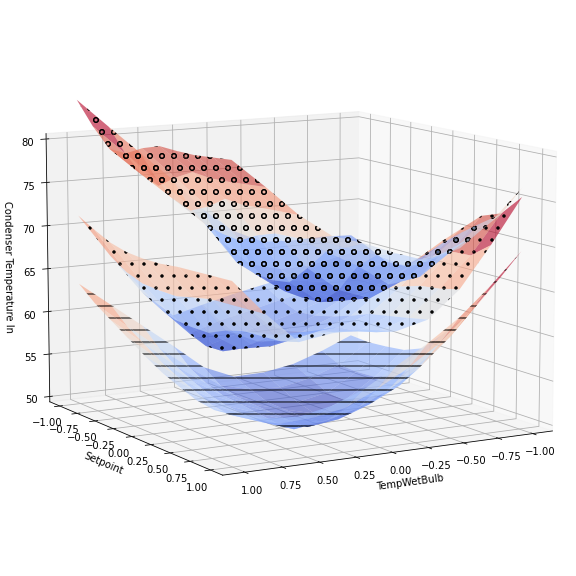

In [628]:
%matplotlib notebook
son = model_surface(lambda x: modelon.predict(x)[:,0], test_point, vary, ((-1,1),(-1,1)), (10,10))

plot_surface(*so, fig_kwargs={'figsize':(8,8)}, cmap=plt.cm.coolwarm, hatch='o', alpha=0.6)
ax = plt.gca()
plot_surface(*sn, cmap=plt.cm.coolwarm, ax=ax, hatch='-', alpha=0.6)
plot_surface(*son, cmap=plt.cm.coolwarm, ax=ax, hatch='.', alpha=0.6)

plt.xlabel(colsx[vary[0]])
plt.ylabel(colsx[vary[1]] if vary[1]<len(colsx) else 'Setpoint')
ax.set_zlim(50, 80)
ax.set_zlabel('Condenser Temperature In')
ax.view_init(10, 60)
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

#### Policy transfer

In [552]:
# transferring across
(agenton, rewardson), (agenton_, rewardson_) = \
    transfer_experiment(agento, agentn, transfer_model=None, timesteps=timesteps, **agent_params)

  0%|          | 0/8640 [00:00<?, ?it/s]

Text(0.5, 1.0, 'RL Performance')

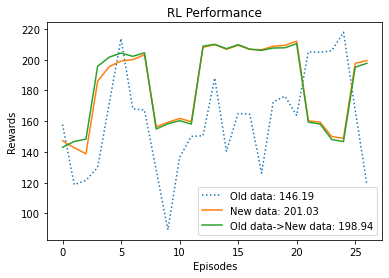

In [553]:
%matplotlib inline
# Learning performance
plt.plot(stats.rolling_mean(rewardso, 4), label='Old data: %.2f' % np.mean(rewardso[-5:]), ls=':')
plt.plot(stats.rolling_mean(rewardsn, 4), label='New data: %.2f' % np.mean(rewardsn[-5:]))
# plt.plot(stats.rolling_mean(rewardson, 4), label='Old data->model->New data: %.2f' % np.mean(rewardson[-5:]))
plt.plot(stats.rolling_mean(rewardson_, 4), label='Old data->New data: %.2f' % np.mean(rewardson_[-5:]))
plt.ylabel('Rewards')
plt.xlabel('Episodes')
plt.legend()
plt.title('RL Performance')

In [571]:
# Operational performance
results = dict(ro=[], rn=[], ron=[], ron_=[], rud=[], rfa=[], rmpc=[])
for i in trange(10, leave=False):
    _seed = i
    results['ro'].append(helpers.get_from_env(('reward',), get_env(modeln, scalern, tickern, _seed), lambda x: agento.predict(x)[0])['reward'][0])
    results['rn'].append(helpers.get_from_env(('reward',), get_env(modeln, scalern, tickern, _seed), lambda x: agentn.predict(x)[0])['reward'][0])
#     results['ron'].append(helpers.get_from_env(('reward',), get_env(modeln, scalern, tickern, _seed), lambda x: agenton.predict(x)[0])['reward'][0])
    results['ron_'].append(helpers.get_from_env(('reward',), get_env(modeln, scalern, tickern, _seed), lambda x: agenton_.predict(x)[0])['reward'][0])

    updown = UpDownController(modeln.predict, scalern.transform, 0)
    results['rud'].append(helpers.get_from_env(('reward',), get_env(modeln, scalern, tickern, _seed), lambda x: updown.predict(x)[0])['reward'][0])
    fixed = FixedApproachController(approach=5)
    results['rfa'].append(helpers.get_from_env(('reward',), get_env(modeln, scalern, tickern, _seed), lambda x: fixed.predict(x)[0])['reward'][0])
    mpc = ModelPredictiveController(modelb.predict, scalerb.transform, resolution=21)
    results['rmpc'].append(helpers.get_from_env(('reward',), get_env(modeln, scalern, tickern, _seed), lambda x: mpc.predict(x)[0])['reward'][0])

keys = list(results.keys())
resaggon = {}
for key in keys:
    if len(results[key])==0: continue
    results[key] = helpers.homogenous_array(results[key])
    resaggon[key+'_mean'] = np.nanmean(results[key], axis=0)
    resaggon[key+'_std'] = np.nanstd(results[key], axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Transfer: sparse to diverse data')

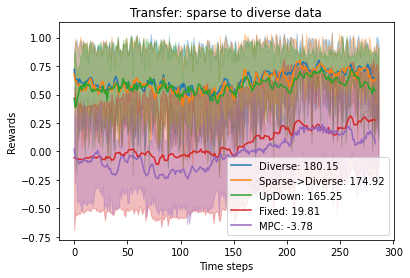

In [573]:
%matplotlib inline
r = resaggon
p = plt.plot(stats.rolling_mean(r['rn_mean'], 4), label='Diverse: {:.2f}'.format(sum(r['rn_mean'])))
plt.fill_between(np.arange(len(r['rn_mean'])), r['rn_mean']+r['rn_std'], r['rn_mean']-r['rn_std'], color=p[0].get_color(), alpha=0.3)
# p = plt.plot(stats.rolling_mean(r['ron_mean'], 4), label='Tower A->model->B: {:.2f}'.format(sum(r['ron_mean'])))
# plt.fill_between(np.arange(len(r['ron_mean'])), r['ron_mean']+r['ron_std'], r['ron_mean']-r['ron_std'], color=p[0].get_color(), alpha=0.3)
p = plt.plot(stats.rolling_mean(r['ron__mean'], 4), label='Sparse->Diverse: {:.2f}'.format(sum(r['ron__mean'])))
plt.fill_between(np.arange(len(r['ron__mean'])), r['ron__mean']+r['ron__std'], r['ron__mean']-r['ron__std'], color=p[0].get_color(), alpha=0.3)
p = plt.plot(stats.rolling_mean(r['rud_mean'], 4), label='UpDown: {:.2f}'.format(sum(r['rud_mean'])))
plt.fill_between(np.arange(len(r['rud_mean'])), r['rud_mean']+r['rud_std'], r['rud_mean']-r['rud_std'], color=p[0].get_color(), alpha=0.3)
p = plt.plot(stats.rolling_mean(r['rfa_mean'], 4), label='Fixed: {:.2f}'.format(sum(r['rfa_mean'])))
plt.fill_between(np.arange(len(r['rfa_mean'])), r['rfa_mean']+r['rfa_std'], r['rfa_mean']-r['rfa_std'], color=p[0].get_color(), alpha=0.3)
p = plt.plot(stats.rolling_mean(r['rmpc_mean'], 4), label='MPC: {:.2f}'.format(sum(r['rmpc_mean'])))
plt.fill_between(np.arange(len(r['rmpc_mean'])), r['rmpc_mean']+r['rmpc_std'], r['rmpc_mean']-r['rmpc_std'], color=p[0].get_color(), alpha=0.3)
plt.ylabel('Rewards')
plt.xlabel('Time steps')
plt.legend()
plt.title('Transfer: sparse to diverse data')